## Module 6 Lab.A - Regression Model Using Spark ML Pipeline
In this analysis we will use the automabile dataset available on UCI ML repository. Our goal is to predict the MPG using variables such as HP, cylinder, and brand(ford, toyota, etc.)

#### 1. Read Data
First things first - let's read the data using the SQL module available in SPARK. 
Then, we might need to inspect the data

In [0]:
# This will create the sql context to read data and read the data and save it as spark_df
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
spark_df = sqlContext.sql("Select * from insurance")

#### 2. Define Target

In [0]:
target = 'charges' # dependent variable in our dataset

#### 3. Check the Dataset

In [0]:
summary = spark_df.describe().toPandas() # describes the dataset and displays the result as pandas dataframe (not spark dataframe)
summary

,summary,age,sex,bmi,children,smoker,region,charges
0,count,1338,1338,1338,1338,1338,1338,1338
1,mean,39.20702541106129,None,30.663396860986538,1.0949177877429,None,None,13270.422265141257
2,stddev,14.049960379216147,None,6.098186911679012,1.205492739781914,None,None,12110.011236693992
3,min,18,female,15.96,0,no,northeast,1121.8739
4,max,64,male,53.13,5,yes,southwest,63770.42801


In [0]:
# have a summary dataframe that gives key descriptive statistics
import pandas as pd
null_list = [spark_df.where(spark_df[x].isNull()).count() for x in spark_df.columns] 
print(null_list)
null_list.insert(0, 'null_count') # insert null-count at index 0
print(null_list)
null_list = pd.DataFrame(null_list).T # make null_count a pandas dataframe and transpose it
null_list.columns = summary.columns
summary = summary.append(null_list) # merge it w/ summary dataframe defned above
summary.index = summary.summary
summary = summary[spark_df.columns]
summary

[0, 0, 0, 0, 0, 0, 0]
['null_count', 0, 0, 0, 0, 0, 0, 0]


<command-3520664774981878>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(null_list) # merge it w/ summary dataframe defned above


,age,sex,bmi,children,smoker,region,charges
summary,,,,,,,
count,1338,1338,1338,1338,1338,1338,1338
mean,39.20702541106129,None,30.663396860986538,1.0949177877429,None,None,13270.422265141257
stddev,14.049960379216147,None,6.098186911679012,1.205492739781914,None,None,12110.011236693992
min,18,female,15.96,0,no,northeast,1121.8739
max,64,male,53.13,5,yes,southwest,63770.42801
null_count,0,0,0,0,0,0,0


#### 4. Determine Categorical and Numerical Variables
This depends on business and doman knowledge. I will replace it w/ median for the sake of simplicity

In [0]:
from pyspark.sql.types import StringType
spark_df = spark_df.withColumn('children', spark_df['children'].cast(StringType()))
spark_df.dtypes

Out[6]: [('age', 'int'),
 ('sex', 'string'),
 ('bmi', 'double'),
 ('children', 'string'),
 ('smoker', 'string'),
 ('region', 'string'),
 ('charges', 'double')]

In [0]:
# identify categorical variables
dtypes = spark_df.dtypes # this will identify the data types of the variables in spark_df
cat_input = [] # create an empty list
for i in range(0, len(spark_df.columns)): #iterate over the variables
  if dtypes[i][1] == 'string': # if dtype is string save it in the cat_input list
    cat_input.append(dtypes[i][0])
cat_input = list(set(cat_input)-set(target))
cat_input

Out[7]: ['children', 'region', 'smoker', 'sex']

/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


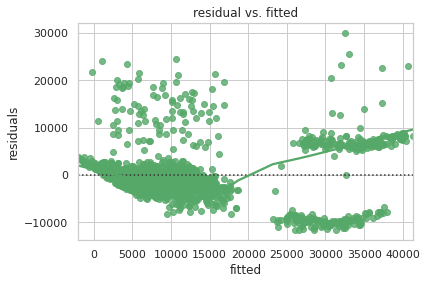

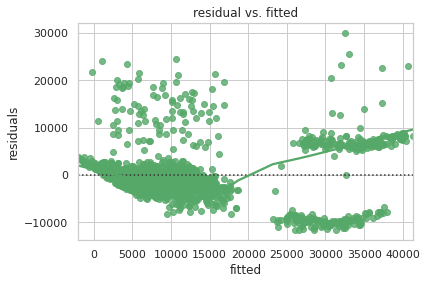

In [0]:
# Residual vs. Fitted Plot
import numpy as np # import numpy
import seaborn as sns # import seaborn for data viz
import matplotlib.pyplot as plt #import matplotlib for data viz
sns.set(style="whitegrid")
fig, ax = plt.subplots() # create figure and axes
x = np.asarray(df_r.select('prediction').toPandas()) # get the predicted sale price and save it as umpy array
x = x.reshape(x.shape[0]) # reshape it
y = np.asarray(summary.residuals.toPandas()) # get the residuals (actual - predicted)
y = y.reshape(y.shape[0]) # reshape it

# Plot the residuals after fitting a linear model (residuals vs predicted (fitted))
sns.residplot(x, y, lowess=True, color="g")
ax.set_title('residual vs. fitted')
ax.set(xlabel='fitted', ylabel='residuals')
display(fig)

In [0]:
# numerical variables
num_input = list(set(spark_df.columns) - set([target]) - set(cat_input)) # the difference of the categorical variables from all the variables will give us the numerical variables. 
num_input

Out[8]: ['age', 'bmi']

#### 5. Create Custom Transformer for Imputation

In [0]:
# impute missing values
from pyspark.sql.types import DoubleType
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col



class NumericImputer(Transformer, HasInputCol, HasOutputCol): # replacing missing values in numerical columns

    def __init__(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
        super(NumericImputer, self).__init__()  # do not change this part at all when creating custom transformers
        self.setParams(inputCol = inputCol , outputCol = outputCol)  # do not change this part at all when creating custom transformers

        
    def setParams(self, inputCol=None, outputCol=None):  # do not change this part at all when creating custom transformers
      return self._set(inputCol = inputCol, outputCol = outputCol)  # do not change this part at all when creating custom transformers
        

    def _transform(self, dataset):  # do not change this part at all when creating custom transformers

      out_col = self.getOutputCol()  # do not change this part at all when creating custom transformers
      in_col = self.getInputCol()  # do not change this part at all when creating custom transformers
    
      
      
      from pyspark.sql.functions import when  
      from pyspark.sql.types import DoubleType
      median_v = dataset.approxQuantile(in_col, [0.5], 0)[0] # compute median #dataset = dataset.fillna(median_v, subset=in_col)
      return dataset.withColumn(out_col, when(col(in_col).isNull(), median_v).otherwise(col(in_col)).cast(DoubleType())) # replacing null values with median if the value is null otherwise keeping it as is

In [0]:
numericimputers = [] # creating an empty list
for column in num_input: # creating a list of numeric imputers each of which responsible for imputing a variable
  numericimputers.append(NumericImputer(inputCol = column , outputCol = column))
numericimputers

Out[10]: [NumericImputer_822175e12c69, NumericImputer_1aa3e59d5897]

#### 6. Create Custom Standardization

In [0]:
# normalize a dataset
from pyspark.sql.types import IntegerType
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType


class Standardizer(Transformer, HasInputCol, HasOutputCol): # creating a standardizer class that will standardize columns (x-mean/3std)
  
    def __init__(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
        super(Standardizer, self).__init__() # do not change this part at all when creating custom transformers
        self.setParams(inputCol = inputCol , outputCol = outputCol) # do not change this part at all when creating custom transformers

        
        
    def setParams(self, inputCol=None, outputCol=None): # do not change this part at all when creating custom transformers
      return self._set(inputCol = inputCol, outputCol = outputCol) # do not change this part at all when creating custom transformers
        

    def _transform(self, dataset): # do not change this part at all when creating custom transformers

      out_col = self.getOutputCol()  # do not change this part at all when creating custom transformers
      in_col = self.getInputCol()  # do not change this part at all when creating custom transformers
      
      from pyspark.sql.functions import stddev, mean, col 
      from pyspark.sql.types import DoubleType
      from pyspark.sql.functions import udf

      mean_ = dataset.select(mean(in_col)).first()[0] # compute mean
      std_ = dataset.select(stddev(in_col)).first()[0] # compute stdev
      udf_c =  udf(lambda x: (x-mean_)/std_, DoubleType()) # create a custom udf that will iteratre over a column and subtract the mean fom each value and divide the result by stdev
      return dataset.withColumn(out_col, udf_c(dataset[in_col])) # standardize the variable and saves the variable as out_col
    

In [0]:
standardizers = [] # creating an empty list
for column in num_input: # creating a list of numeric imputers each of which responsible for imputing a variable
  standardizers.append(Standardizer(inputCol = column, outputCol = column+"_standardized"))
standardizers

Out[12]: [Standardizer_c1a4233cf87b, Standardizer_af15baa2fb00]

#### 7. Create Dummies (Convert Categorical Variables into 0-1 Dummy Variables)

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

indexers = [StringIndexer(inputCol = column, outputCol = column+"_index") for column in cat_input] # this will first create indexers (it means it will number each category in a variable)
encoders = [OneHotEncoder(inputCol = column+"_index", outputCol = column+"_dummy") for column in cat_input] # This will use the numbers to create the binary variables
encoders

Out[13]: [OneHotEncoder_ebdb4b0a27bd,
 OneHotEncoder_5d3fe970830c,
 OneHotEncoder_063982061bab,
 OneHotEncoder_235f7912c777]

#### 8. Determine Input Variables (Features)

In [0]:
input_cols = [] # creates an empty list
for i in cat_input: #iterates over categorical variables
  input_cols.append(i+"_dummy") # saves the name of the dummy encoded categorical variables (they are not categorical now though)
for i in num_input: # iterates over the numerical variables
  input_cols.append(i+"_standardized") # saves the name of standardized numerical variables
input_cols

Out[14]: ['children_dummy',
 'region_dummy',
 'smoker_dummy',
 'sex_dummy',
 'age_standardized',
 'bmi_standardized']

#### 9. Add more stages to the Pipeline

In [0]:
assembler = VectorAssembler(inputCols= input_cols, outputCol="features") # takes the input variables and saves it as a vector

In [0]:
lr = LinearRegression(featuresCol = 'features', labelCol = target,maxIter=10, regParam=0.3, elasticNetParam=0.8) # this is designed the buiold a regression model using the target variable and the features vector which is a vector contaiing the input_variables (input_cols)

#### 10. Combine the stages as a list

In [0]:
import functools 
import operator
stages = [] # creates an empty list
stages = functools.reduce(operator.concat, [numericimputers, indexers, encoders, standardizers]) # it will combine the pipeline elements such as numeric imputers, indexers, etc.
stages.append(assembler) #it will add the assembler stage
stages.append(lr) # it will add the linear regression stage
stages

Out[17]: [NumericImputer_822175e12c69,
 NumericImputer_1aa3e59d5897,
 StringIndexer_ac78d4e2039b,
 StringIndexer_04d30379e249,
 StringIndexer_476f9e82ae54,
 StringIndexer_9e2005e408fc,
 OneHotEncoder_ebdb4b0a27bd,
 OneHotEncoder_5d3fe970830c,
 OneHotEncoder_063982061bab,
 OneHotEncoder_235f7912c777,
 Standardizer_c1a4233cf87b,
 Standardizer_af15baa2fb00,
 VectorAssembler_74729ebf1c92,
 LinearRegression_b13ca82feb64]

In [0]:
# First missing values will be imputed, then categorical variables will be dummy encoded, then numerical variables will be standardized, then input variables will be saved as a vector, and finally, a linear regression model will be built based on the stages given above. 

#### 11. Run The Pipeline

In [0]:
# RUN THE PIPELINE
pipeline = Pipeline(stages=stages) # creates the pipeline object
df_r = pipeline.fit(spark_df).transform(spark_df) # runs the pipeline and saves the result in df_r

#### 12. Evaluate Performance

In [0]:
# Computes R square
from pyspark.sql import functions as F
from pyspark.sql.functions import pow
mean_y = df_r.select(F.mean('charges')).collect().pop()[0] # computes the average sale price
mean_y
df_r = df_r.withColumn('mean_Y*sq', pow(df_r['charges']-mean_y, 2)) # subtracts the mean sale price from sale price, squares it, and saves it as mean_Y*sq
df_r = df_r.withColumn('Y-Yhat*sq', pow(df_r['charges']-df_r['prediction'], 2)) # subtract the predicted sale price from actual sale price, squares it, and saves it as  Y-Yhat*sq
R_sq = 1-df_r.agg(F.sum(df_r['Y-Yhat*sq'])).collect().pop()[0]/df_r.agg(F.sum(df_r['mean_Y*sq'])).collect().pop()[0] # divides the sum of mean_Y*sy by the sum of Y_Yhat*sq and subtract it from 1. 
print(R_sq)

0.7519186168172595


In [0]:
# Computes r square in an easier way using spark's functions
summary = pipeline.fit(spark_df).stages[-1].summary # after fitting the pipeline we get the model summary of the last stage which is linear regression
print("numIterations: %d" % summary.totalIterations)
print("RMSE: %f" % summary.rootMeanSquaredError)
print("r2: %f" % summary.r2)
print("objectiveHistory: %s" % str(summary.objectiveHistory))
#summary.residuals.show()

numIterations: 10
RMSE: 6029.471968
r2: 0.751919
objectiveHistory: [0.4999999999999999, 0.41349831900553236, 0.1953614053613003, 0.12490486180796827, 0.12453404590840936, 0.12421774911462827, 0.1241432875327263, 0.12410639318118225, 0.12407529144463333, 0.12407207474017903, 0.12407137485791114]
